In [19]:
%load_ext autoreload
%autoreload 2

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/src')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


In [22]:
# If a function was added to the package, I have to reload the specific module rather than the whole package
importlib.reload(lcwgsus)

<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

In [10]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

kinship = pd.read_csv( "results/chip/qc/PCs/chip_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')

In [4]:
snp_missing = 0.05
snp_hwe = 1e-6
sample_missing = 0.05
heterozygosity_nstd = 3

snp = snp[snp['missing_proportion'] < 0.2]
snp = snp[snp['HW_exact_p_value'] > snp_hwe]
snp = snp[snp['missing_proportion'] < snp_missing]

sample = sample[sample['missing_proportion'] < sample_missing]
std = sample['heterozygous_proportion'].std()
mean = sample['heterozygous_proportion'].mean()
sample = sample[(sample['heterozygous_proportion'] > mean - heterozygosity_nstd*std) & (sample['heterozygous_proportion'] < mean + heterozygosity_nstd*std)]

In [5]:
chromosomes = [i for i in range(1,23)]
oneKGmafs = ["/well/band/users/rbx225/GAMCC/data/oneKG_MAFs/oneKG_MAF_afr_chr" + str(i) + ".txt" for i in chromosomes]
oneKGaf = lcwgsus.multi_read_af(chromosomes, oneKGmafs)
oneKGaf = oneKGaf.rename(columns = {'MAF': 'prop'})
oneKGaf['prop'] = np.where(oneKGaf['prop'] > 0.5, 1 - oneKGaf['prop'], oneKGaf['prop'])

In [6]:
chromosomes = [i for i in range(1,23)]
GGVPmafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
af = lcwgsus.multi_read_af(chromosomes, GGVPmafs)
af = af.rename(columns = {'MAF': 'prop'})
af['prop'] = np.where(af['prop'] > 0.5, 1 - af['prop'], af['prop'])

chip_af = snp[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
chip_af = chip_af.rename(columns = {'chromosome': 'chr', 'position': 'pos', 'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
chip_af = chip_af[chip_af['chr'].isin([str(i) for i in range(1,23)])]
chip_af['chr'] = chip_af['chr'].astype(int)
chip_af['ref'] = chip_af['ref'].astype(str)
chip_af['alt'] = chip_af['alt'].astype(str)

9.755270435044369e-01

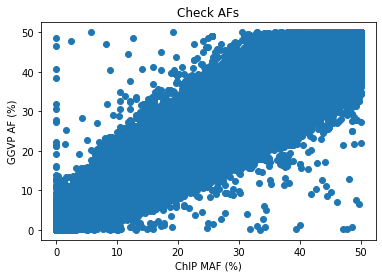

In [7]:
# This is oneKG vs chip
lcwgsus.plot_afs(chip_af, oneKGaf, save_fig = False)

0.9698125528589632

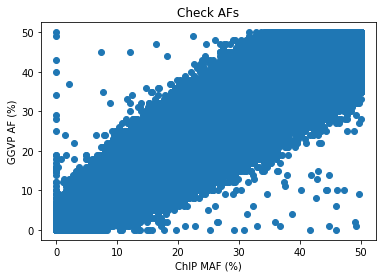

In [23]:
# This is GGVP vs chip
lcwgsus.plot.plot_afs(chip_af, af, save_fig = False)

In [41]:
res = pd.merge(chip_af, af, on = ['chr', 'pos', 'ref', 'alt'])
res = res[(res['prop_y'] != 0) & (res['prop_y'] != 1)]
delta = ((res['prop_x'] - res['prop_y'])**2/(res['prop_y']*(1-res['prop_y']))).sum()/(2*res.shape[0])
res['z'] = (res['prop_x'] - res['prop_y'])/np.sqrt(res['prop_y']*(1-res['prop_y']))
res.shape[0]

516634

(0.0, 50.0)

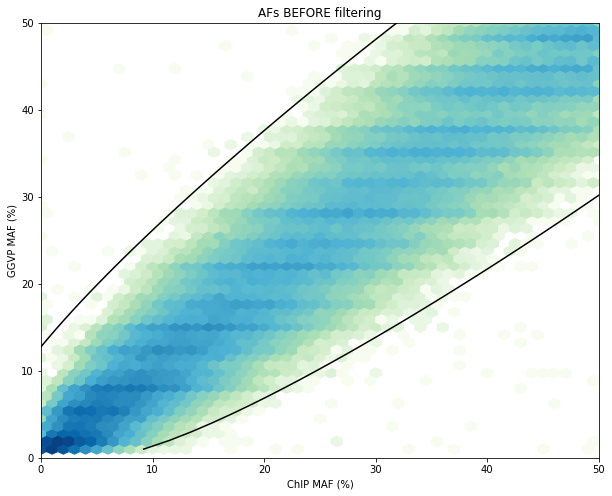

In [38]:
nstd = 4

y = np.arange(1,51)/100

xp = nstd*np.sqrt(y*(1-y)*delta) + y+0.05
xm = -nstd*np.sqrt(y*(1-y)*delta) + y-0.02

plt.figure(figsize=(10, 8))
plt.hexbin(res['prop_x']*100, res['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs BEFORE filtering')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

(0.0, 50.0)

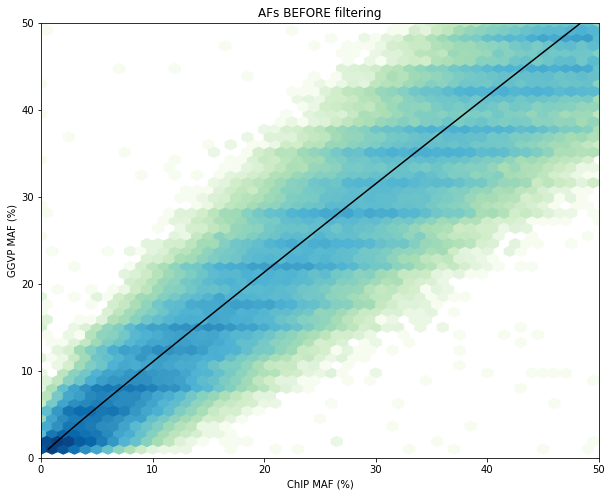

In [14]:
y = np.arange(1,51)/100

xp = nstd*delta*np.sqrt(y*(1-y)) + y
xm = -nstd*delta*np.sqrt(y*(1-y)) + y

plt.figure(figsize=(10, 8))
plt.hexbin(res['prop_x']*100, res['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs BEFORE filtering')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

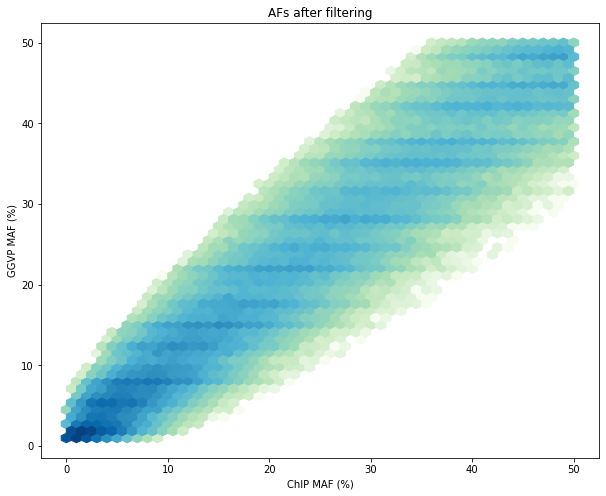

In [43]:
filtered = res[((res['prop_x'] - res['prop_y']-0.05)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta)) & 
          ((-res['prop_x'] + res['prop_y']+0.02)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta))]

plt.figure(figsize=(10, 8))
plt.hexbin(filtered['prop_x']*100, filtered['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs after filtering')
plt.show()

# res.shape[0] = 512548

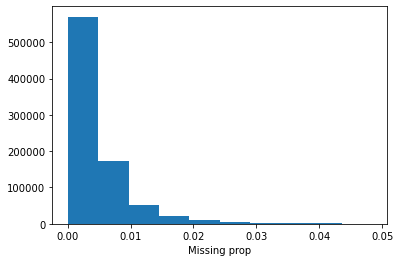

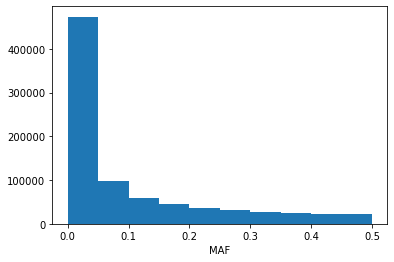

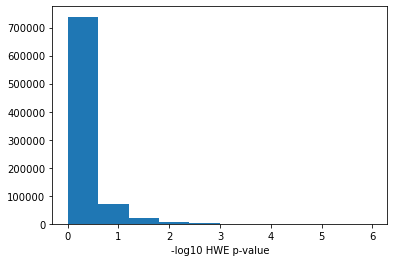

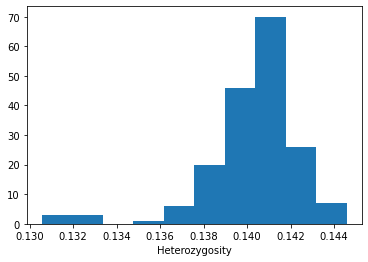

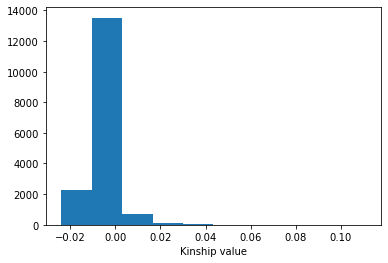

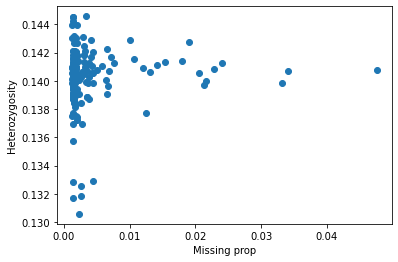

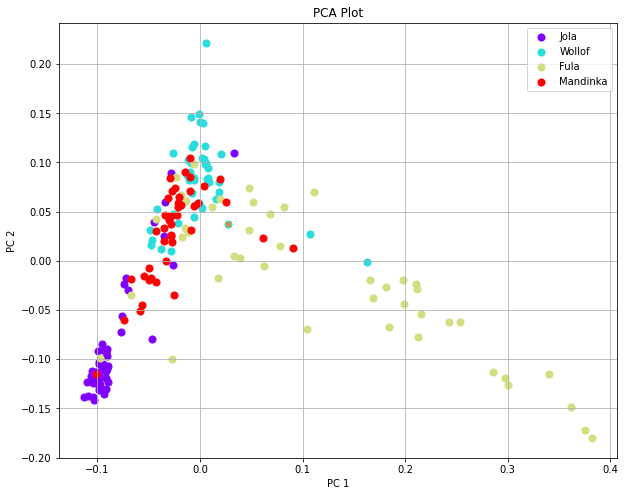

In [31]:
plt.hist(snp['missing_proportion'])
plt.xlabel('Missing prop')
plt.show()

plt.hist(snp['minor_allele_frequency'])
plt.xlabel('MAF')
plt.show()

plt.hist(-np.log10(snp['HW_exact_p_value']))
plt.xlabel('-log10 HWE p-value')
plt.show()

plt.hist(sample['heterozygous_proportion'])
plt.xlabel('Heterozygosity')
plt.show()

plt.hist(kinship[kinship['sample_1'] != kinship['sample_2']]['value'])
plt.xlabel('Kinship value')
plt.show()

plt.scatter(sample['missing_proportion'], sample['heterozygous_proportion'])
plt.xlabel('Missing prop')
plt.ylabel('Heterozygosity')
plt.show()

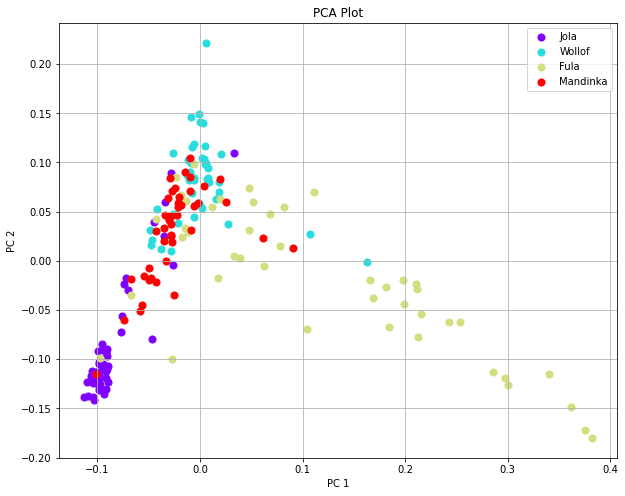

In [11]:
lcwgsus.plot_pc(PC)

<Figure size 720x576 with 0 Axes>

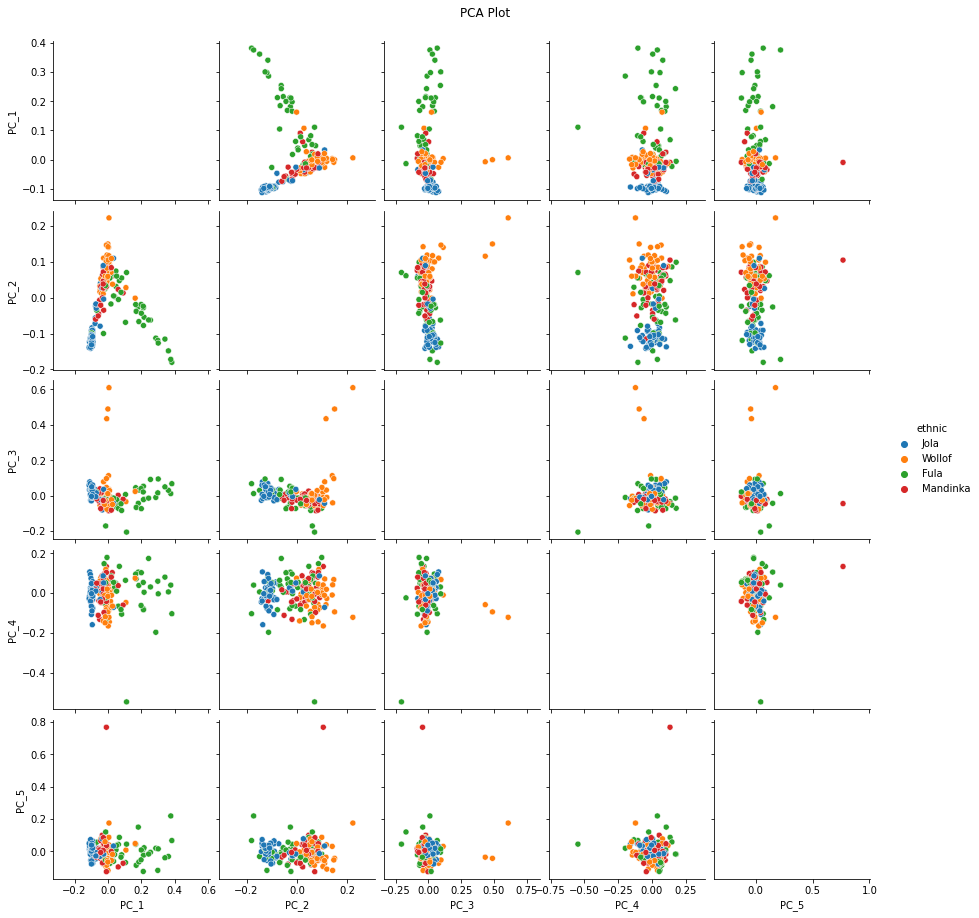

In [23]:
lcwgsus.plot.plot_pc(PC, 5)

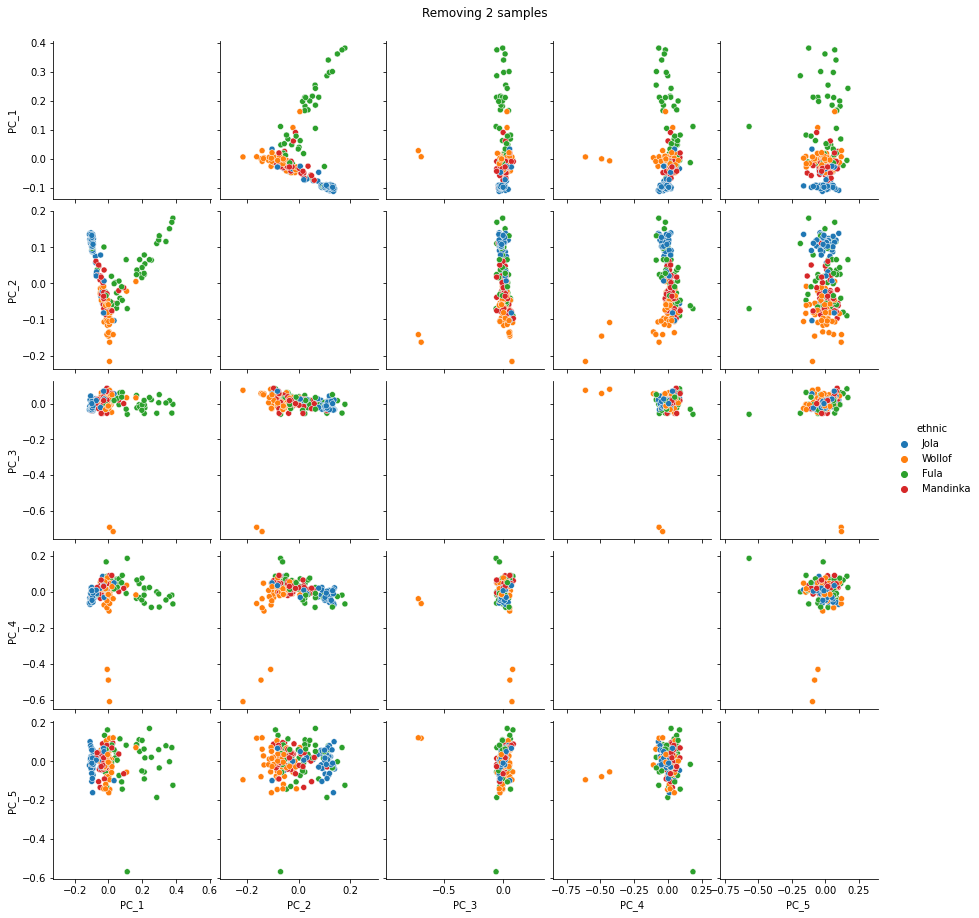

In [30]:
db2 = sqlite3.connect( "results/chip/qc/chip.qc.gavin.sqlite" )
PC2 = pd.read_sql_query( "SELECT * FROM PCsView", db2 )
PC2 = PC2[PC2['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC2 = PC2.merge(ethnic, on = 'sample_id', how = 'left')
plot = sns.pairplot(PC2[['PC_' + str(i) for i in range(1,6)] + ['ethnic']], hue="ethnic", diag_kind="kde", diag_kws={"linewidth": 0, "shade": False})
plot.fig.suptitle('Removing 2 samples', y = 1.02)
plt.show()

In [46]:
chip_filtered = filtered.drop(columns = ['ref', 'alt', 'prop_x', 'prop_y', 'z'])
chip_filtered.to_csv('results/chip/vcf/retain_sites.tsv', sep = '\t', header = False, index = False)
samples_removed = pd.DataFrame({'samples': ['GAM370894', 'GAM916387', 'GAM654203']}) 
samples_removed.to_csv('results/chip/vcf/drop_samples.tsv', sep = '\t', header = False, index = False)